## <b>■ 복습</b>
    1장
    2장
    3장
    4장
    5장
    6장
    7장. CNN + Fully Connected
        Image -----> Convolution ----------------> Pooling ----------------> Fully Connected
                     여러개의 Feature map           Feature map 선명하게             분류
                     이미지의 특징 추출
                              ↓                            ↓                       ↓
                     Convolution class 생성         Pooling class 생성        5장 오차역전파 3층 신경망  
    
    8장. 딥러닝의 역사
![hist](http://cfile252.uf.daum.net/image/992CCB4F5F3472F40F4BEF)
![hist2](http://cfile253.uf.daum.net/image/9969A7455F3473150F3FDF)

## <b>■ 밑바닥 딥러닝 책 최종 스크립트의 큰 그림</b>
### <b>□ 필기체 데이터를 CNN 신경망에 넣어서 학습시키는 그림</b>
![learn1](learn1.png)
![learn2](http://cfile249.uf.daum.net/image/99BA49355F3465D00CD4EA)

<b>첫번째 그림</b>
#### 예제1. 28x28 필기체 데이터 100장을 생성

In [8]:
import numpy as np
x = np.random.randn(100,1,28,28)
print(x.shape)

(100, 1, 28, 28)


#### 예제2. 5x5 필터 30장 생성

In [3]:
w1 = np.random.randn(30,1,5,5)
print(w1.shape)

(30, 1, 5, 5)


#### 예제3. 위에서 만든 입력값 x와 필터 w1을 합성곱한 feature map을 생성하고 shape를 확인하시오

In [4]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2 * pad - filter_h) // stride + 1
    out_w = (W + 2 * pad - filter_w) // stride + 1

    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride * out_h
        for x in range(filter_w):
            x_max = x + stride * out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)
    return col

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = int(1+ (H+ 2*self.pad - FH) / self.stride)
        out_w = int(1+ (W+ 2*self.pad - FW) / self.stride)
        
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        
        out = out.reshape(N, out_h, out_w, -1).transpose(0,3,1,2)
        
        return out

In [10]:
b1 = 1
con = Convolution(w1, b1)
feature_map = con.forward(x)
print(feature_map.shape)

(100, 30, 24, 24)


#### 예제4. Convolution 계층을 통과한 output을 pooling 계층에 통과시키고 나온 output 사이즈를 확인하시오

In [11]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        return out

In [12]:
pool = Pooling(2,2,stride=2)
pool_out = pool.forward(feature_map)
print(pool_out.shape)

(100, 30, 12, 12)


#### 예제5. 위의 pooling계층을 통과한 출력 데이터가 완전 연결계층에 들어가서 가중치와 내적할 수 있도록 가중치 w2를 생성하시오

In [14]:
w2 = np.random.randn(30*12*12, 100)

#### 예제6. 완전 연결계층의 w2와 내적한 후 더하기 할 b2를 생성하시오

In [13]:
b2 = np.zeros(100)

#### 예제7. 완전연결 계층의 마지막 출력층인 w3와 b3를 각각 생성하시오

In [17]:
w3 = np.random.randn(100,10)
b3 = np.zeros(10)
print(w3.shape)

(100, 10)


#### 예제8. pooling층을 통과한 pool_out이 완전연결계층으로 들어가서 나온 결과 shape를 출력하시오

In [19]:
pool_out2 = pool_out.reshape(100,-1)
fully_out1 = np.dot(pool_out2, w2) + b2
fully_out2 = np.dot(fully_out1, w3) + b3
print(fully_out2.shape)

(100, 10)


## <b>■ CNN을 사용한 신경망 전체 코드</b>
    밑바닥부터 시작하는 딥러닝 최종 스크립트의 큰 설계도
        이미지 --------> Convolution --------> Pooling --------> Affine1 --------> Affine2 --------> 분류결과
                            1층                                    2층               3층

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

class SimpleConvNet:
    """단순한 합성곱 신경망

    conv - relu - pool - affine - relu - affine - softmax

    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'                                        
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    ###############################
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
    ###############################
        filter_num = conv_param['filter_num']  # 30
        filter_size = conv_param['filter_size']    #  5
        filter_pad = conv_param['pad']   # 0
        filter_stride = conv_param['stride']  # 1
        input_size = input_dim[1]             # 28
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1 # 24
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
                                     #   30  *  12  * 12 
        # conv_output_size와 pool_output_size는 완전연결계층에서 가중치 W2를 생성하기 위해 필요
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
               # 0.01 *  np.random.rand ( 30, 1, 5, 5 ) 
        self.params['b1'] = np.zeros(filter_num)  #  30 
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
              # 0.01 * np.random.randn( 30 * 12 * 12, 100 )
        self.params['b2'] = np.zeros(hidden_size)  # 100 
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
             #  0.01 * np.random.randn( 100, 10 ) 
        self.params['b3'] = np.zeros(output_size)  # 10 

        # 계층 생성
        self.layers = OrderedDict()
        
        ######################################
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        ######################################
        
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size:(i + 1) * batch_size]
            tt = t[i * batch_size:(i + 1) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        #########################
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        #########################
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i + 1)]
            self.layers[key].b = self.params['b' + str(i + 1)]

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch) # 600

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크

    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        print(x_train.shape) # 60000,784
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### ※ 문제108. 위의 cnn을 모함한 신경망 코드의 설계도를 아래와 같이 변경하고 학습시키시오
    이미지 -------> conv1 -------> ReLU -------> pooling -------> Affine1 
                   (W1: 32)                                      (W2: 50)

Saved Network Parameters!
600.0
(60000, 1, 28, 28)
train acc, test acc | 0.14338333333333333, 0.1437
(60000, 1, 28, 28)
train acc, test acc | 0.9413666666666667, 0.9459
(60000, 1, 28, 28)
train acc, test acc | 0.9685166666666667, 0.9706
(60000, 1, 28, 28)
train acc, test acc | 0.9787, 0.9794
(60000, 1, 28, 28)
train acc, test acc | 0.9829833333333333, 0.9822
(60000, 1, 28, 28)
train acc, test acc | 0.9835833333333334, 0.9828
(60000, 1, 28, 28)
train acc, test acc | 0.9849833333333333, 0.9816
(60000, 1, 28, 28)
train acc, test acc | 0.9859833333333333, 0.9835
(60000, 1, 28, 28)
train acc, test acc | 0.9878, 0.9836
(60000, 1, 28, 28)
train acc, test acc | 0.9872333333333333, 0.9863
(60000, 1, 28, 28)
train acc, test acc | 0.9885833333333334, 0.9855
(60000, 1, 28, 28)
train acc, test acc | 0.9891, 0.9867
(60000, 1, 28, 28)
train acc, test acc | 0.9899833333333333, 0.9861
(60000, 1, 28, 28)
train acc, test acc | 0.9904666666666667, 0.9865
(60000, 1, 28, 28)
train acc, test acc | 0.99056666

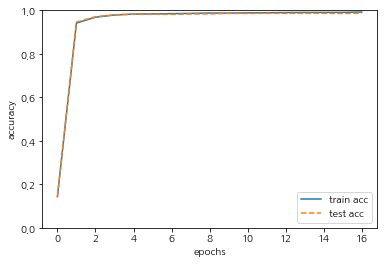

In [20]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.trainer import Trainer

class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param={'filter_num': 32, 'filter_size': 5, 'pad': 0, 'stride': 1},
                 hidden_size=50, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']  # 30
        filter_size = conv_param['filter_size']    #  5
        filter_pad = conv_param['pad']   # 0
        filter_stride = conv_param['stride']  # 1
        input_size = input_dim[1]             # 28
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1 # 24
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))
                                     #   30  *  12  * 12 
        # conv_output_size와 pool_output_size는 완전연결계층에서 가중치 W2를 생성하기 위해 필요
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
               # 0.01 *  np.random.rand ( 30, 1, 5, 5 ) 
        self.params['b1'] = np.zeros(filter_num)  #  30 
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
              # 0.01 * np.random.randn( 30 * 12 * 12, 100 )
        self.params['b2'] = np.zeros(hidden_size)  # 100 

        # 계층 생성
        self.layers = OrderedDict()
        
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i * batch_size:(i + 1) * batch_size]
            tt = t[i * batch_size:(i + 1) * batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1']):
            self.layers[key].W = self.params['W' + str(i + 1)]
            self.layers[key].b = self.params['b' + str(i + 1)]

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
# x_train, t_train = x_train[:5000], t_train[:5000]
# x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1, 28, 28),
                        conv_param={'filter_num': 32, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=50, output_size=10, weight_init_std=0.01)

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0] # 60000 개
batch_size = 100  # 미니배치 크기
learning_rate = 0.1
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)
print(iter_per_epoch) # 600

for i in range(iters_num): # 10000
    # 미니배치 획득  # 랜덤으로 100개씩 뽑아서 10000번을 수행하니까 백만번
    batch_mask = np.random.choice(train_size, batch_size) # 100개 씩 뽑아서 10000번 백만번
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    # 매개변수 갱신

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss) # cost 가 점점 줄어드는것을 보려고
    # 1에폭당 정확도 계산 # 여기는 훈련이 아니라 1에폭 되었을때 정확도만 체크

    if i % iter_per_epoch == 0: # 600 번마다 정확도 쌓는다.
        print(x_train.shape) # 60000,784
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc) # 10000/600 개  16개 # 정확도가 점점 올라감
        test_acc_list.append(test_acc)  # 10000/600 개 16개 # 정확도가 점점 올라감
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

### <b>■ LeNet5 </b>
    CNN 알고리즘
![lenet](http://cfile260.uf.daum.net/image/996E3B455F34692D0D63D0)
![lenet2](http://cfile285.uf.daum.net/image/996886455F346C500ECD8F)

    이미지 -------> conv1 -------> pooling --------> conv2 -------> pooling --------> Fully connected (은닉->출력)
                                                                                    Affine1 ----> Affine2

    LeNet 신경망부터는 텐서플로우로 구현
    
## <b>■ Tensor Flow</b>
    다차원 흐름
    
    4차원 배열의 연산(계산)을 빠르게 할 수 있게끔 구현 가능
        1. 코드가 간결
        2. 신경망 구현에 필요한 모든 함수들이 다 내장
        3. 속도가 빠름(코딩 및 실행)
        4. GPU 사용 가능
            Window에서 GPU 사용 가능하도록 지원
            
### <b>■ Tensor Flow 구조</b>
    모델을 생성하는 부분
        - 변수
    모델을 실행하는 부분
        -세션
    
![tensor](http://cfile264.uf.daum.net/image/991BCF3359892BB313FF4B)

### <b>■ Tensor Flow 용어</b>
    1. 오퍼레이션(Operation)
        그래프 상의 노드를 오퍼레이션
        하나 이상의 텐서를 받을 수 있다
        계산을 수행하고 결과를 하나 이상의 텐서로 반환할 수 있다
        
    2. Tensor
        내부적으로 모든 데이터는 텐서를 통해 표현
        텐서는 일종의 다차원 배열, 그래프 내의 오퍼레이션간에 텐서가 전달
        
    3. 세션(Session)
        그래프를 실행하기 위해서는 세션 객체가 필요
        오퍼레이션의 실행환경을 캡슐화 한 것
    
    4. 변수
        그래프의 실행 시 파라미터를 저장하고 갱신하는데 사용
        메모리상의 텐서를 저장하는 버퍼의 역할

### ※ 문제109. (오늘의 마지막 문제) 현재 구성한 가상환경에 텐서플로우가 잘 수행되는지 확인하시오
    1. 텐서 플로우 1.x: snowdeer_env
    2. 텐서 플로우 2.x: keras_study